<center>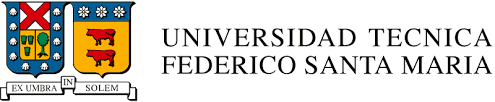</center>



<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477/577 Redes Neuronales Artificiales - 2022-2 </h1>

<H3 align='center'> Tarea 2: Grape disease detection  </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Carga de datos y preprocesamientos
* Convoluciones y parámetros
* Profundidad
* Image Data Augmentation
* Bloque Residual
* Bloque Inception
* Transfer Learning


**Formalidades**  
* Equipos de trabajo de 3 personas (*Los estudiantes deben estar preparados para presentar la tarea el día de la entrega*).
* El entregable debe ser un _Jupyter Notebook_ incluyendo los códigos utilizados, los resultados, los gráficos realizados y comentarios. Debe seguir una estructura similar a un informe (se debe introducir los problemas a trabajar, presentar los resultados y discutirlos), se penalizará fuertemente ausencia de comentarios, explicaciones de gráficos, _etc_. Si lo prefiere puede entregar un _Jupyter Notebook_ por pregunta o uno por toda la tarea, con tal de que todos los entregables esten bien identificados y se encuentren en el mismo repositorio de _Github_.
* Se debe preparar una presentación del trabajo realizado y sus hallazgos. El presentador será elegido aleatoriamente y deberá apoyarse en el _Jupyter Notebook_ que entregarán. 
* Formato de entrega: envı́o de link del repositorio en _Github_, al correo electrónico de los ayudantes (<maryon.morales@sansano.usm.cl>, <sebastian.sanchezl@sansano.usm.cl>), en copia al profesor (<cvalle@inf.utfsm.cl>). Especificar el siguiente asunto: [INF-395/477/577-2022-2 Tarea 2]. Invitar como colaborador a los usuarios de github "ssanchezl" y "maryonmorales" para poder acceder al repositorio en caso de ser privado.

* Fecha de presentaciones 11 de Noviembre, en horario de clases.
* Fecha de entrega: 12 de Noviembre. Hora límite de entrega: 12:00 p.m. Cualquier _commit_ luego de la hora límite no será evaluado. Se realizará descuento por atrasos en envío del mail igualmente.

<hr style="height:2px;border:none"/>

La tarea tiene ejemplos de códigos con los cuales pueden guiarse en gran parte, sin embargo, **solo son guias** y pueden ser creativos al momento de resolver la tarea. Soluciones creativas o elegantes serán valoradas. También en algunas ocaciones se hacen elecciones arbitrarias, ustedes pueden realizar otras elecciones con tal de que haya una pequeña justificación de por qué su elección es mejor o equivalente.
Recuerden intercalar su código con *comentarios* en celdas _Markdown_, con los comentarios de la pregunta y con cualquier análisis, fórmula (en $ \LaTeX $) o explicación que les parezca relevante para justificar sus procedimientos. *No respondan las preguntas en comentarios en el código*.
Noten que en general cuando se les pide elegir algo o proponer algo no se evaluará tanto la elección en si, sino que la argumentación detrás de la elección será lo más ponderado.
Si algún modelo se demora demasiado en correr en su máquina, no olvide que puede correr _Jupyter Notebooks_ en _Collab_ de Google, incluso con la opción de aceleración con GPU (particularmente útil para los modelos más grandes), esto puede ser relevante para las máquinas más lentas al momento de realizar exploraciones con _K-folds_ o las redes más grandes. Existe también la posibilidad de utilizar _Google Cloud Plataform_ o _Amazon Web Service_, donde tienen máquinas aceleradas con GPU; maquinas ya configuradas para _deep leraning_ pueden encontrarse en el _Marketplace_ de cada proveedor de servicios.

## 1 - Redes Convolucionales para la detección de enfermedades en la uva.

### Información y anexos

En esta oportunidad se trabajará con un conjunto de imágenes de hojas de las plantas de uva y la tarea será identificar cuál de las 3 enfermedades esta presente en la plante o si esta sana, a partir de las imágenes entregadas. A continuación se presentan 4 sitios en para encontrar más información acerca de las enfermedades de las uvas, de las cuales se trabajará con las últimas 3 listadas:

- [Diseases of Grape (Vitis spp.)](https://web.archive.org/web/20080223134516/http://www.apsnet.org/online/common/names/grape.asp)

- [Black rot](http://ipm.illinois.edu/diseases/series700/rpd703/)

- [Black Measles](https://ieeexplore.ieee.org/document/9397205)

- [Isariopsis leaf spot](http://horticulturejournal.usamv.ro/pdf/2017/Art33.pdf)



## Python libraries

In [14]:
import zipfile as zf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import filecmp as fcmp
import os
import scipy as sp
from PIL import Image

import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import gradient_descent_v2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import History, EarlyStopping

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit

from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow import Tensor

## 1.a Carga de datos y visualizaciones


Establezca la ubicación de los datos.

In [15]:
from pathlib import Path


data_dir  = Path.cwd()/'Grape'

Descomprima los datos.

In [16]:
# with zf.ZipFile(data_zip_path, 'r') as zip_ref:
#     zip_ref.extractall(data_dir)
# data_dir_Grapes = data_dir+ '/Grape'


Revise las imágenes de cada carpeta y cargue las imágenes en un arreglo $X$, el nombre de la carpeta indica el nombre de cada clase $y$. Cargue los nombres de las clases en un arreglo de tal forma que cada imagen $X$ esté asociada a su respectiva clase $y$.

In [17]:
X = list()
y = list()

for dirname, _, filenames in os.walk(data_dir):           
    for filename in filenames: 
        image = Image.open(os.path.join(dirname, filename))
        X.append(np.array(image, dtype=np.uint8))
        disease = dirname.split('\\')[-1][8:] # get the name of the disease
        y.append(disease)   
X = np.asarray(X)
y = np.asarray(y)

#...

### ¿Qué porcentaje del total de imagenes tiene cada clase? ¿Están balanceadas las clases?

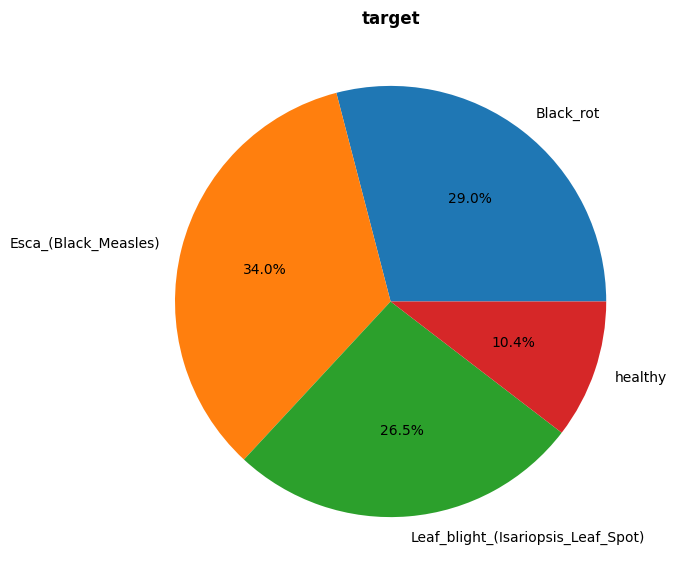

In [18]:
many = []
labels = []
for cls, n in zip(*np.unique(y, return_counts=True)):
    many.append(n) 
    labels.append(cls)

plt.figure(figsize = (7, 7))
plt.pie(many, labels = labels, autopct='%0.0001f%%')
plt.title("target", fontweight="bold")
plt.show()

El grafico de torta, nos entrega los porcentajes de las clases con las que contamos en el data set, podemos evidenciar cierto desbalance en el dataset, en particular la clase de plantas sanas, es consireablamente más pequeña que el resto, es menos de la mitad de la siguiente clase más pequeña. Esto puede ser un problema para el entrenamiento de la red, ya que la red puede tener problemas aprendiendo a distinguir una hoja sana de una hoja enferma, pero el desbalance tampoco es extremo como en otros problemas.



### Visualice algunas imágenes de cada una de las clases junto con sus nombres y revise sus dimensiones y tipo de dato.

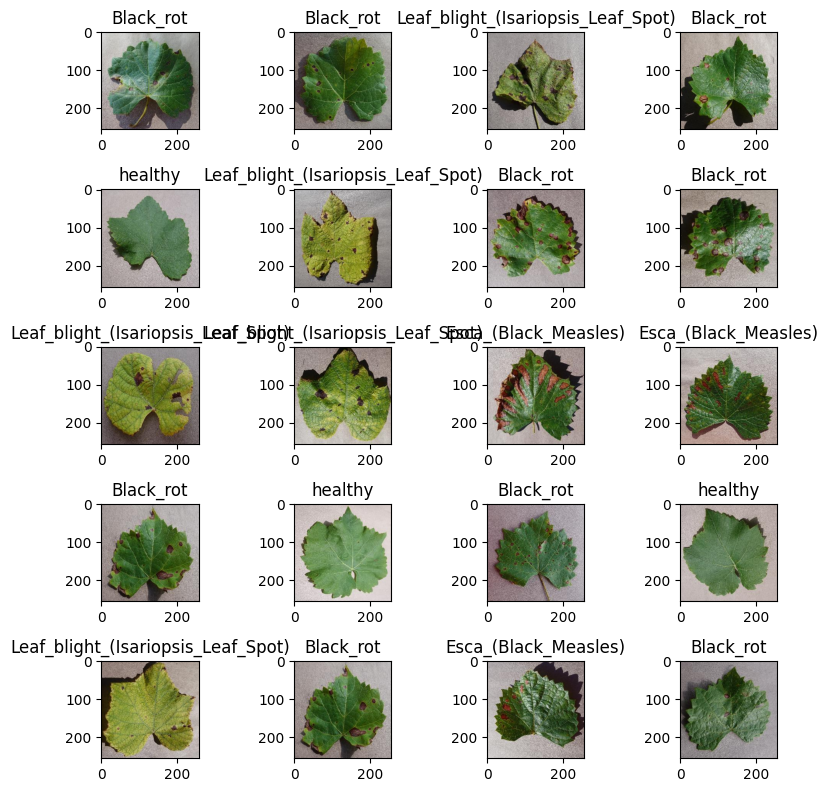

In [19]:
import random
import matplotlib.image as mpimg
from tkinter import image_names



fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
labels = list()
 
for i in range(0, columns*rows):
    n = random.randint(0, len(X))
    img = X[n]
    fig.add_subplot(rows, columns, i+1)
    plt.gca().set_title(y[n])
    plt.imshow(img)

fig.tight_layout(pad=1.0)


plt.show()

Aquí podemo ver una muestra de las imágenes, está se toma de forma aleatoria, así que en teoría podrian repetirse, pero el dataset es lo suficientemente grande para que eso no sea un problema.  Ahora, las dimensiones de las imágenes parecen ser todas iguales, pero deberíamos verificar este hecho

In [20]:
sizes = [img.shape for img in X]
print(f'Set of image sizes: {set(sizes)}')

Set of image sizes: {(256, 256, 3)}


En efecto, todas las imágenes tienen las mismas dimensiones. Veamos ahora cmo están compuestas.

In [21]:
X[0][:2]

array([[[103,  88,  95],
        [111,  96, 103],
        [117, 102, 109],
        ...,
        [174, 167, 174],
        [170, 163, 170],
        [165, 158, 165]],

       [[108,  93, 100],
        [114,  99, 106],
        [117, 102, 109],
        ...,
        [170, 163, 170],
        [168, 161, 168],
        [163, 156, 163]]], dtype=uint8)

In [22]:
X.max(), X.min()

(255, 0)

In [23]:
len(X)

4062

Podemos ver que la imágenes son tensores de 3x256x256, lo que significa que son imágenes a color de 256x256 pixeles. Los valores dentro de cada imágen son enteros entre 0 y 255. Notemos también que tenemos 4062 imágenes. 

## 1.b Preprocesamiento


Transforme $y$ a encoding one hot vector, para esto utilice la librería de SciKit Learn. OneHotEncoder recibe valores categóricos numéricos, por lo que las clases en formato string deben ser transformados vía Label Encoding antes de aplicar One Hot Encoding.

### Label Encoding

In [24]:
# Creating instance of labelencoder
le = LabelEncoder()

# Fit the transformer
le.fit(y)
y_le = le.transform(y)
le.classes_

array(['Black_rot', 'Esca_(Black_Measles)',
       'Leaf_blight_(Isariopsis_Leaf_Spot)', 'healthy'], dtype='<U34')

### OneHotEncoding

In [25]:
# Creating instance of onehotencoder
ohe = OneHotEncoder(handle_unknown='ignore')

# Fit the transformer
ohe.fit(y_le.reshape(-1, 1))
y_ohe = ohe.transform(y_le.reshape(-1, 1)).toarray()

y_ohe

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

### Conjuntos de datos
Separe los datos en conjuntos de entrenamiento, validación y prueba. Elija un porcentaje para separar los conjuntos y justifique.

In [26]:
sf = StratifiedShuffleSplit(n_splits=1, test_size=0.9, random_state=42)

for train_index, val_index in sf.split(X, y_ohe):
    X_train, X_test = X[train_index], X[val_index]
    y_train, y_test = y_ohe[train_index], y_ohe[val_index]  

In [27]:
sf2 = StratifiedShuffleSplit(n_splits=1, test_size=8.5/9, random_state=42)

for train_index, test_index in sf2.split(X_train, y_train):
    X_train, X_val = X_train[train_index], X_train[test_index]
    y_train, y_val = y_train[train_index], y_train[test_index]  

Elegimos quedarnos con un 5% de los datos para el conjunto de validación y un 10% para el conjunto de prueba, lo que nos deja un 85% de los datos entrenar. Elegímos está cantidad dado que, aunque es más grande que el estandar, la base de datos no es extensa y queremos que el modelo tenga suficientes datos para aprender. 

Notemos que la función de arriba tiene la particularidad de mantener las proporicones del dataset original, así que tendremos el mismo balance entre los conjuntos de entrenamiento, validación y test.

### Normalización de los datos

Por ahora los valores de los píxeles de las imágenes se encuentran en el rango $[0,255]$. Normalice cada canal RGB por separado y obtenga $\langle(\mu_R,\sigma^2_R), (\mu_G,\sigma^2_G), (\mu_B,\sigma^2_B)\rangle_\text{Train Set}$ y luego use estos parámetros para normalizar los 3 conjuntos separados en la preguna anterior.

In [28]:
# Perform Standarization
def prep_normalize(X_train, X_val, X_test):
    x_means = X_train.mean(axis=(0,1,2), keepdims=True)
    x_std = X_train.std(axis=(0,1,2), keepdims=True)
    
    X_train	= ((X_train - x_means) / x_std).astype(np.float32)
    X_val   = ((X_val - x_means) / x_std).astype(np.float32)
    X_test  = ((X_test - x_means) / x_std).astype(np.float32)
    # Standarize each channel separately.
    return X_train, X_val, X_test

In [29]:
X_train, X_val, X_test = prep_normalize(X_train, X_val, X_test)

## 1.c Primera Red Convolucional


Entrenaremos una primera red convolucional sobre los datos, con la mayoría de los parámetros por defecto. Cree primero una red con la siguiente la estructura $C \times P \times C \times P \times D\times D$, donde $C$ representa una capa convolucional, $P$ una capa Max Pooling y $D$ una capa densa. Note que antes de la capa densa debe agregar una capa Flatten que transforma los filtros a vectores que luego pueden ser utilizados por la capa densa.

Para los parámetros de las capas, fijaremos ambas capas convolucionales con 128 filtros de $3 \times 3$, stride por default de $1 \times 1$, y padding "same", es decir, agregaremos $0$ a los bordes de la imágen de tal manera que se preserve la dimension de la imágen al atravesar la capa, las capas de pooling tendrán tamaño y stride $2\times 2$, como muentra el código. 

Utilice el método `.summary` del modelo para ver la cantidad de parámetros y las dimensiones de los outputs de cada capa. Justifique el número de parámetros y el Output Shape de cada capa en función de la estructura de la red y lo aprendido en clase.

Preguntas:

Investigue y explique qué es el stride en la capa convolucional, ¿Qué operación efectúa la activación SoftMax y qué representaría en términos del problema el vector de salida de la red?

$\textit{R:}$ EL stride es el tamaño del salto que realiza el kernel en la imagen para construir el feature map, un stride de 1 en este contexto significa dar saltos de un pixel.

La softmax realiza una normalización de las salidas, dando como resultados las "probabilidades de que el target pertenezca a cada categoría", el vector de salida representa esta probabilidad o seguridad de nuestra red a que el input dado tendrá en las categorías a las que podría pertenecer. Esto lo realiza mediante la siguiente ecuación.

$$ f(z_{i})=\frac{e^{z_{i}}}{\displaystyle \sum^{I}_{j=1}e^{z_{j}}}$$




In [21]:
def baseline_model(inputs,num_classes):    
    x = inputs
    # create model    
    conv1  = Conv2D(filters = 128,
                    kernel_size = (3,3),
                    strides=(1, 1),
                    padding = 'same',
                    activation = 'relu',
                    data_format="channels_last")(x)

    pool1  = MaxPooling2D(pool_size = (2,2))(conv1)

    conv2  = Conv2D(filters = 128,
                    kernel_size = (3,3),
                    strides=(1, 1),
                    padding = 'same',
                    activation = 'relu')(pool1)

    pool2  = MaxPooling2D(pool_size = (2,2))(conv2)    

    dense1 = Dense(units=32, activation='relu')(Flatten()(pool2))    

    dense2 = Dense(units=num_classes, activation='softmax')(dense1)

    model  = Model(inputs = inputs, outputs = dense2)    
    
    return model

In [22]:
first_model = baseline_model(Input(shape=(256,256,3)), 3)
first_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 524288)            0     

En orden:

- input_1: La capa de entrada no tiene parámetros, solo recibe los datos de entrada. Dado esto, el output shape es el mismo que el mismo de las imágenes, i.e., (256, 256, 3).
- conv2d: Tenemos 128 filtros de 3x3, cada filtro tiene 9 parámetros, además tenemos 3 canales por cada imágen, y por último hay un bias por cada filtro, por lo que tenemos 128x9x3 + 128 = 3584 parámetros. Como el padding es "same", por lo que la dimensión de la imágen no cambia, además tenemos 128 filtros, por lo que el output shape es (256, 256, 128).
- max_pooling2d: La capa de pooling no tiene parámetros, solo reduce la dimensión de la cada imágen de entrada. Como el pooling es de tamaño 2x2, el output shape en cada dirección es la mitad del anterior, pero mantenemos las 128 imágenes filtradas (128, 128, 128).
- conv2d_1: Tenemos 128 filtros de 3x3, cada filtro tiene 9 parámetros, además tenemos 128 resultados de los filtros anteriores, y por último hay un bias por cada filtro, por lo que tenemos 128x9x128 + 128 = 147584 parámetros. Como el padding es "same", por lo que la dimensión de la imágen no cambia, además tenemos 128 filtros, por lo que el output shape es (128, 128, 128).
- max_pooling2d_1: La capa de pooling no tiene parámetros, solo reduce la dimensión de la cada imágen de entrada. Como el pooling es de tamaño 2x2, el output shape en cada dirección es la mitad del anterior, pero mantenemos las 128 imágenes filtradas (64, 64, 128).
- flatten: La capa de flatten no tiene parámetros, solo transforma los filtros (2d) a vectores(1d). Como tenemos 128 imágenes filtradas, cada una de 64x64, nos queda 64x64x128=524288, por lo que el output shape es (524288,).
- dense: Tenemos 32 neuronas, cada neurona tiene 64x64x128 conexiones con la capa flatten, además hay un bias por cada neurona, por lo que tenemos 32x524288+32 = 16777248 parámetros. Como tenemos 32 neuronas, el output shape es (32,).
- dense_1: Tenemos 3 neuronas, cada neurona tiene 32 conexiones con la capa anterior, además hay un bias por cada neurona, por lo que tenemos 32x3+3 = 99 parámetros. Como tenemos 3 neuronas, el output shape es (3,).



Compile la red definida en el item anterior. Para esta pregunta puede usar la activación, el optimizador, learning rate y learning rate decay que usted desee con sus respectivos argumentos, justificando su elección, y debe usar como loss Categorical Crossentropy.

Entrene la red hasta observar convergencia recuperando su history. Grafique como varía el accuracy en entrenamiento y validación a lo largo del aprendizaje. Adicionalmente obtenga el accuracy para todo el conjunto de test.

Preguntas: ¿Por qué preferimos medir crossentropy y no por ejemplo MSE en este problema?¿Qué valor representa el accuracy?, ¿Le parece buena medida de desempeño para este problema?

Debido a que es un problema de clasificación, tiene más sentido la metrica de error de crossentropy, pues MSE responde a problemas de naturaleza de regresión. El accuracy representa la proporción de aciertos realizados sobre el total de predicciones realizadas, sigue la siguiente formula.

$$\text{accuracy}=\frac{\text{Predicciones acertadas}}{\text{Predicciones totales}}$$

Utilizar el accuracy para este problema de clasificación se ve menos ventajoso que utilizar la crossentrophy, pues la crossentrophy nos permite distinguir que modelo es mejor ante el mismo valor de accuracy en un escenario tal que ambos modelos tengan el mismo accuracy pero con distintos niveles de confianza en sus predicciones, además nos permite evaluar mejor la capacidad de generalización del modelo.

In [27]:
inputs = Input(shape=X_train.shape[1:])
num_classes = 4

# build the model
model = baseline_model(inputs,num_classes)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

my_callbacks = [History(), EarlyStopping(patience=10, min_delta=0.01, monitor='val_accuracy', mode="auto", restore_best_weights = True)]

# Fit the model
with tf.device("/CPU:0"):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=300, callbacks=my_callbacks)

Epoch 1/200
1/1 [==============================] - 76s 76s/step - loss: 1.4232 - accuracy: 0.1364 - val_loss: 41.5774 - val_accuracy: 0.2917
Epoch 2/200
1/1 [==============================] - 17s 17s/step - loss: 38.9847 - accuracy: 0.2727 - val_loss: 38.2461 - val_accuracy: 0.3385
Epoch 3/200
1/1 [==============================] - 19s 19s/step - loss: 36.2143 - accuracy: 0.3636 - val_loss: 12.9093 - val_accuracy: 0.3464
Epoch 4/200
1/1 [==============================] - 16s 16s/step - loss: 11.6268 - accuracy: 0.4545 - val_loss: 3.6021 - val_accuracy: 0.2656
Epoch 5/200
1/1 [==============================] - 15s 15s/step - loss: 3.3418 - accuracy: 0.2727 - val_loss: 1.8819 - val_accuracy: 0.2656
Epoch 6/200
1/1 [==============================] - 16s 16s/step - loss: 1.8294 - accuracy: 0.2727 - val_loss: 1.1586 - val_accuracy: 0.4740
Epoch 7/200
1/1 [==============================] - 16s 16s/step - loss: 1.0931 - accuracy: 0.4545 - val_loss: 1.4262 - val_accuracy: 0.3464
Epoch 8/200
1/

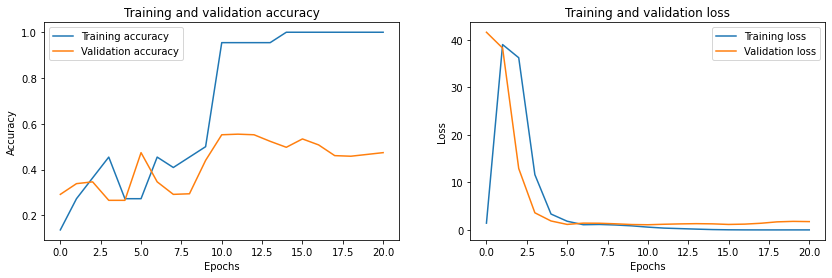

In [28]:
plt.rcParams["figure.figsize"]=[14,4]
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# Test evaluation of the model
with tf.device("/CPU:0"):
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

In [31]:
print(f'Loss in test data: {test_loss}\nAccuracy in test data: {test_acc}')

Loss in test data: 1.0575149059295654
Accuracy in test data: 0.5716630220413208


## 1.d Parámetros de la capa Convolucional

## están corridas, falta concluir

Entrene la misma red (arquitectura $C\times P\times C\times P\times D\times D$) de la pregunta anterior. A continuación en cada punto debe probar las variaciones que se le indican, manteniendo el resto tal como estaba. Por ejemplo si está probando distintos números de filtros, solo se modifica el número de filtros; si está probando distintos kernel size, entonces el número de filtros volverá a fijarse en 128 como estaba en la pregunta anterior.

+ filters (pruebe 2 números, ej: 512, 32),
+ kernel_size (pruebe $1\times 1$, $5\times 5$, $7\times 7$ y $9\times 9$),
+ strides (pruebe (2,2) y (3,3))
+ padding (pruebe valid),
+ dilation_rate (pruebe 1,2,3)
+ MaxPooling y AveragePooling (en ambos casos pruebe stride de (3,3), (5,5))
+ Dense (pruebe con 2 capas densas con 2 números de neuronas distintos en cada capa (sin contar la de salida softmax de 4 clases), por ejemplo: 

$$\cdots \times D(units=64)\times D(units=32)\times D(num\_ clases, ``softmax"),$$
$$\cdots \times D(units=128)\times D(units=8)\times D(num\_ clases, ``softmax"),$$
$$\cdots \times D(units=256)\times D(num\_ clases, ``softmax"),$$
$$\cdots \times D(units=16)\times D(num\_ clases, ``softmax").$$

Lea la documentación de esta herramienta e investigue cuales de estos parámetros se pueden combinar para realizar una búsqueda en grilla (¿Qué es una búsqueda en grilla?) y cuales no son compatibles entre ellos para ciertos valores, explique por qué.


$\textit{R1:}$ Una busqueda de grilla es una exploración en los hiperparametros, la cual tiene por objetivo, encontrar la combinación optima de hiperparametros, para el/los modelos que se entrenarán.

$\textit{R2:}$ La documentación de keras informa que para dilatiation_rate distintos de 1, son incompatibles con strides distintos de 1, por lo cual realizar un greedsearch con el dilatiation_rate, se debe tener en consideración aquello.

Formule la dimensión de salida $(H_{out}, W_{out})$ en función de la dimensión de entrada $(H_{in}, W_{in})$, el tamaño del kernel $k$, el stride $s$, el padding $p$ y el dilation_rate $d$.

$\textit{R3:}$ $H_{out}=H_{in}/s$

In [24]:
# parameters_to_test = {'filters': [64, 256],
#                       'kernel_size': [(3,3), (5,5), (7,7), (9,9)],
#                       'strides': [(1,1), (2,2)],
#                       'padding': ['valid'],
#                       'dilation_rate': [ (2,2), (3,3)],
#                       'pooling_function': [MaxPooling2D(strides=(3, 3)), MaxPooling2D(strides=(5,5)) , AveragePooling2D(strides=(3, 3)), AveragePooling2D(strides=(5,5))],
#                       'dense_layers': [[16], [32], [64,32], [128,8]],
#                       }

# class parameters_nn:
#     def __init__(self):
#         self.inputs = Input(shape=X_train.shape[1:])
#         self.num_classes = 4
#         self.filters = 128
#         self.kernel_size = (3,3)
#         self.strides=(1,1)
#         self.padding = 'same'
#         self.dilation_rate=(1,1)
#         self.activation = 'relu'
#         self.pooling_function = MaxPooling2D(strides=(2,2))
#         self.dense_layers = [32]

# def p_model(parameters_object):     
#     x = parameters_object.inputs
#     # create model    
#     conv1  =Conv2D(filters  = parameters_object.filters,
#                     kernel_size = parameters_object.kernel_size,
#                     strides = parameters_object.strides,
#                     padding = parameters_object.padding,
#                     dilation_rate = parameters_object.dilation_rate,
#                     activation = parameters_object.activation,
#                     data_format = 'channels_last')(x)

#     pool1  = parameters_object.pooling_function(conv1)

#     conv2  =Conv2D(filters  = parameters_object.filters,
#                     kernel_size = parameters_object.kernel_size,
#                     strides = parameters_object.strides,
#                     padding = parameters_object.padding,
#                     dilation_rate = parameters_object.dilation_rate,
#                     activation = parameters_object.activation,
#                     data_format = 'channels_last')(pool1)

#     pool2  = parameters_object.pooling_function(conv2)    
    
#     if len(parameters_object.dense_layers) == 1:
#         dense1 = Dense(units= parameters_object.dense_layers[0], activation='relu')(Flatten()(pool2))    

#         dense2 = Dense(units= parameters_object.num_classes, activation='softmax')(dense1)

#         model  = Model(inputs = parameters_object.inputs, outputs = dense2)  
#     else:
#         dense1 = Dense(units= parameters_object.dense_layers[0], activation='relu')(Flatten()(pool2))    
#         dense2 = Dense(units= parameters_object.dense_layers[1], activation='relu')(dense1)
#         dense3 = Dense(units= parameters_object.num_classes, activation='softmax')(dense2)

#         model  = Model(inputs = parameters_object.inputs, outputs = dense3)

    
#     return model


# # print('----------------------\n\n\nbeginning grid testing\n\n\n----------------------')

# parameters_object = parameters_nn()
# funcs = ['max33', 'max55', 'avg33', 'avg55']
# fun = 0
# for parameter_name in parameters_to_test.keys():
#     for parameter_value in parameters_to_test[parameter_name]:
#         setattr(parameters_object, parameter_name, parameter_value)
#         print(f'set: {parameter_name} = {parameter_value}')
#         model = p_model(parameters_object)
#         model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#         my_callbacks = [History(), EarlyStopping(patience=10, min_delta=0.01, monitor='val_accuracy', mode="auto", restore_best_weights = True)]

#         # Fit the model
#         history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=300, callbacks=my_callbacks)

#         # save history to dataframe and save to csv
#         history_df = pd.DataFrame(history.history)
#         if parameter_name == 'pooling_function':
#             parameter_value = funcs[fun]
#             fun += 1
#         history_df.to_csv(f'history_{parameter_name}_{parameter_value}.csv')
        

#         # Test evaluation of the model
#         test_loss, test_acc = model.evaluate(X_test, y_test)

#         print(f'Loss in test data: {test_loss}\nAccuracy in test data: {test_acc}')
        
#         # save test results to csv
#         with open(f'test_results_{parameter_name}_{parameter_value}.csv', 'w') as f:
#             f.write(f'Loss in test data: {test_loss}\nAccuracy in test data: {test_acc}')

#         # save model
#         model.save(f'model_{parameter_name}_{parameter_value}.h5')


#         tf.keras.backend.clear_session()

#     parameters_object = parameters_nn()

## 1.e Bloque $C\times C\times P$


Cree y entrene redes utilizando *bloques* $C\times C\times P$ (dos capas convolucionales seguida de una de maxpool) y luego dos capas densas, por ejemplo la estructura de una red de 2 *bloques* sería la siguiente: $\underbrace{C\times C\times P}_{\text{bloque 1}} \times \underbrace{C\times C\times P}_{\text{bloque 2}}\times D \times D$. Puede agregar las capas densas que desee basandose en la experiencia de las preguntas anteriores o lo aprendido en clases (justifique).

La idea es explorar qué ocurre a medida que se modifica la profundidad de la red. Para esto, entrene redes con distintos números de *bloques*. Debe a lo menos entrenar una red por cada número de *bloques*: entre 1 y 5 *bloques*.

Comente sobre los dos casos extremos (1 y 5 *bloques*), ¿le parece que alguno de los dos sea buena aproximación para la clasificación de estas imágenes? Para cada red recupere history y grafique los valores de accuracy en entrenamiento y validación.

$\textit{R:}$ Entre los dos modelos estudiados, evidenciamos que el modelo de 1 bloque se desempeña mejor que el de 5 bloques, creemos que esto es debido a que el modelo de 5 bloques, esta excesivamente sobreparametrizado, en contrario de los 5 bloques, aunque debemos destacar, que el mejor desempeño fue el de 2 bloques, lo cual creemos que para este problema con su contexto es la forma ideal de abordar el problema, pues no contamos con un exceso de parametros a la vez que damos un alto numero de los mismos. El test loss de 1 bloque fue 1.5530, mientras que el de 5 bloques fue 5.7595, de referencia tenemos el de 2 bloques el cual tuvo un loss de 1.3285.

Quedan a su discreción los parámetros de cada capa convolucional, sin embargo, para el número de filtros en las capas convolucionales se recomienda disminuir el número de filtros por la mitad en cada *bloque* por ejemplo: $C(filters=128)\times C(filters=128)\times P \times C(filters=64)\times C(filters=64)\times P\times \cdots \times D \times \cdots \times D.$





In [17]:
#cnn with variable amount of convolutional layers
def cnn_model(inputs,num_classes,conv_blocks,conv_filters):
    x = inputs
    # create model    
    for i in range(conv_blocks):
        conv1  = Conv2D(filters = conv_filters[i],
                        kernel_size = (3,3),
                        strides=(1, 1),
                        padding = 'valid',
                        activation = 'relu',
                        data_format="channels_last")(x)
        conv2  = Conv2D(filters = conv_filters[i],
                        kernel_size = (3,3),
                        strides=(1, 1),
                        padding = 'valid',
                        activation = 'relu',
                        data_format="channels_last")(conv1)

        pool1  = MaxPooling2D(pool_size = (2,2))(conv2)

        x = pool1

    dense1 = Dense(units=32, activation='relu')(Flatten()(x))
    

    dense2 = Dense(units=num_classes, activation='softmax')(dense1)

    model  = Model(inputs = inputs, outputs = dense2)    
    
    return model

def power2list(length, number):
    return [int(number/2**i) for i in range(length)]


In [18]:
inputs = Input(shape=X_train.shape[1:])
num_classes = 4

conv_blocks = [4,5]
conv_filters = [power2list(5, 256) for i in range(5)]
conv_filters.reverse()

with tf.device("/CPU:0"):
    for n_blocks, n_filters in zip(conv_blocks, conv_filters):
        model = cnn_model(inputs, num_classes, n_blocks, n_filters)

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        my_callbacks = [History(), EarlyStopping(patience=20, min_delta=0.01, monitor='val_accuracy', mode="auto", restore_best_weights = True)]

        # Fit the model
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=200, callbacks=my_callbacks)

        # save history to dataframe and save to csv
        history_df = pd.DataFrame(history.history)
        history_df.to_csv(f'history_{n_blocks}_convs.csv')


        # Test evaluation of the model
        test_loss, test_acc = model.evaluate(X_test, y_test)

        print(f'Loss in test data: {test_loss}\nAccuracy in test data: {test_acc}')

        # save test results to csv
        with open(f'test_results_{n_blocks}_convs.csv', 'w') as f:
            f.write(f'Loss in test data: {test_loss}\nAccuracy in test data: {test_acc}')

        # save model
        model.save(f'mode_{n_blocks}_convs')

        tf.keras.backend.clear_session() 


Epoch 1/200
1/1 [==============================] - 109s 109s/step - loss: 1.3968 - accuracy: 0.1364 - val_loss: 1.3350 - val_accuracy: 0.2656
Epoch 2/200
1/1 [==============================] - 85s 85s/step - loss: 1.3187 - accuracy: 0.2727 - val_loss: 1.4694 - val_accuracy: 0.3542
Epoch 3/200
1/1 [==============================] - 85s 85s/step - loss: 1.3213 - accuracy: 0.4545 - val_loss: 1.3422 - val_accuracy: 0.3047
Epoch 4/200
1/1 [==============================] - 82s 82s/step - loss: 1.2270 - accuracy: 0.3636 - val_loss: 1.3074 - val_accuracy: 0.3385
Epoch 5/200
1/1 [==============================] - 81s 81s/step - loss: 1.1632 - accuracy: 0.3636 - val_loss: 1.3977 - val_accuracy: 0.3438
Epoch 6/200
1/1 [==============================] - 82s 82s/step - loss: 1.1220 - accuracy: 0.4091 - val_loss: 1.2761 - val_accuracy: 0.3516
Epoch 7/200
1/1 [==============================] - 82s 82s/step - loss: 1.0320 - accuracy: 0.5000 - val_loss: 1.3084 - val_accuracy: 0.3125
Epoch 8/200
1/1 [=

INFO:tensorflow:Assets written to: mode_4_convs\assets


INFO:tensorflow:Assets written to: mode_4_convs\assets


Epoch 1/200
1/1 [==============================] - 78s 78s/step - loss: 1.3824 - accuracy: 0.3636 - val_loss: 1.3372 - val_accuracy: 0.3307
Epoch 2/200
1/1 [==============================] - 75s 75s/step - loss: 1.3310 - accuracy: 0.3636 - val_loss: 1.4120 - val_accuracy: 0.3385
Epoch 3/200
1/1 [==============================] - 76s 76s/step - loss: 1.3114 - accuracy: 0.3636 - val_loss: 1.3056 - val_accuracy: 0.3385
Epoch 4/200
1/1 [==============================] - 75s 75s/step - loss: 1.2457 - accuracy: 0.3636 - val_loss: 1.2905 - val_accuracy: 0.3385
Epoch 5/200
1/1 [==============================] - 75s 75s/step - loss: 1.2340 - accuracy: 0.3636 - val_loss: 1.2690 - val_accuracy: 0.3411
Epoch 6/200
1/1 [==============================] - 75s 75s/step - loss: 1.1770 - accuracy: 0.4091 - val_loss: 1.3243 - val_accuracy: 0.3464
Epoch 7/200
1/1 [==============================] - 76s 76s/step - loss: 1.1470 - accuracy: 0.5000 - val_loss: 1.3201 - val_accuracy: 0.3464
Epoch 8/200
1/1 [===

INFO:tensorflow:Assets written to: mode_5_convs\assets


INFO:tensorflow:Assets written to: mode_5_convs\assets


# GRAFICAR accuracy del history de los 5 bloques, si quieres grafica los loss.

In [6]:
'./histories/history_{i}_convs.csv'

'history_{i}_convs'

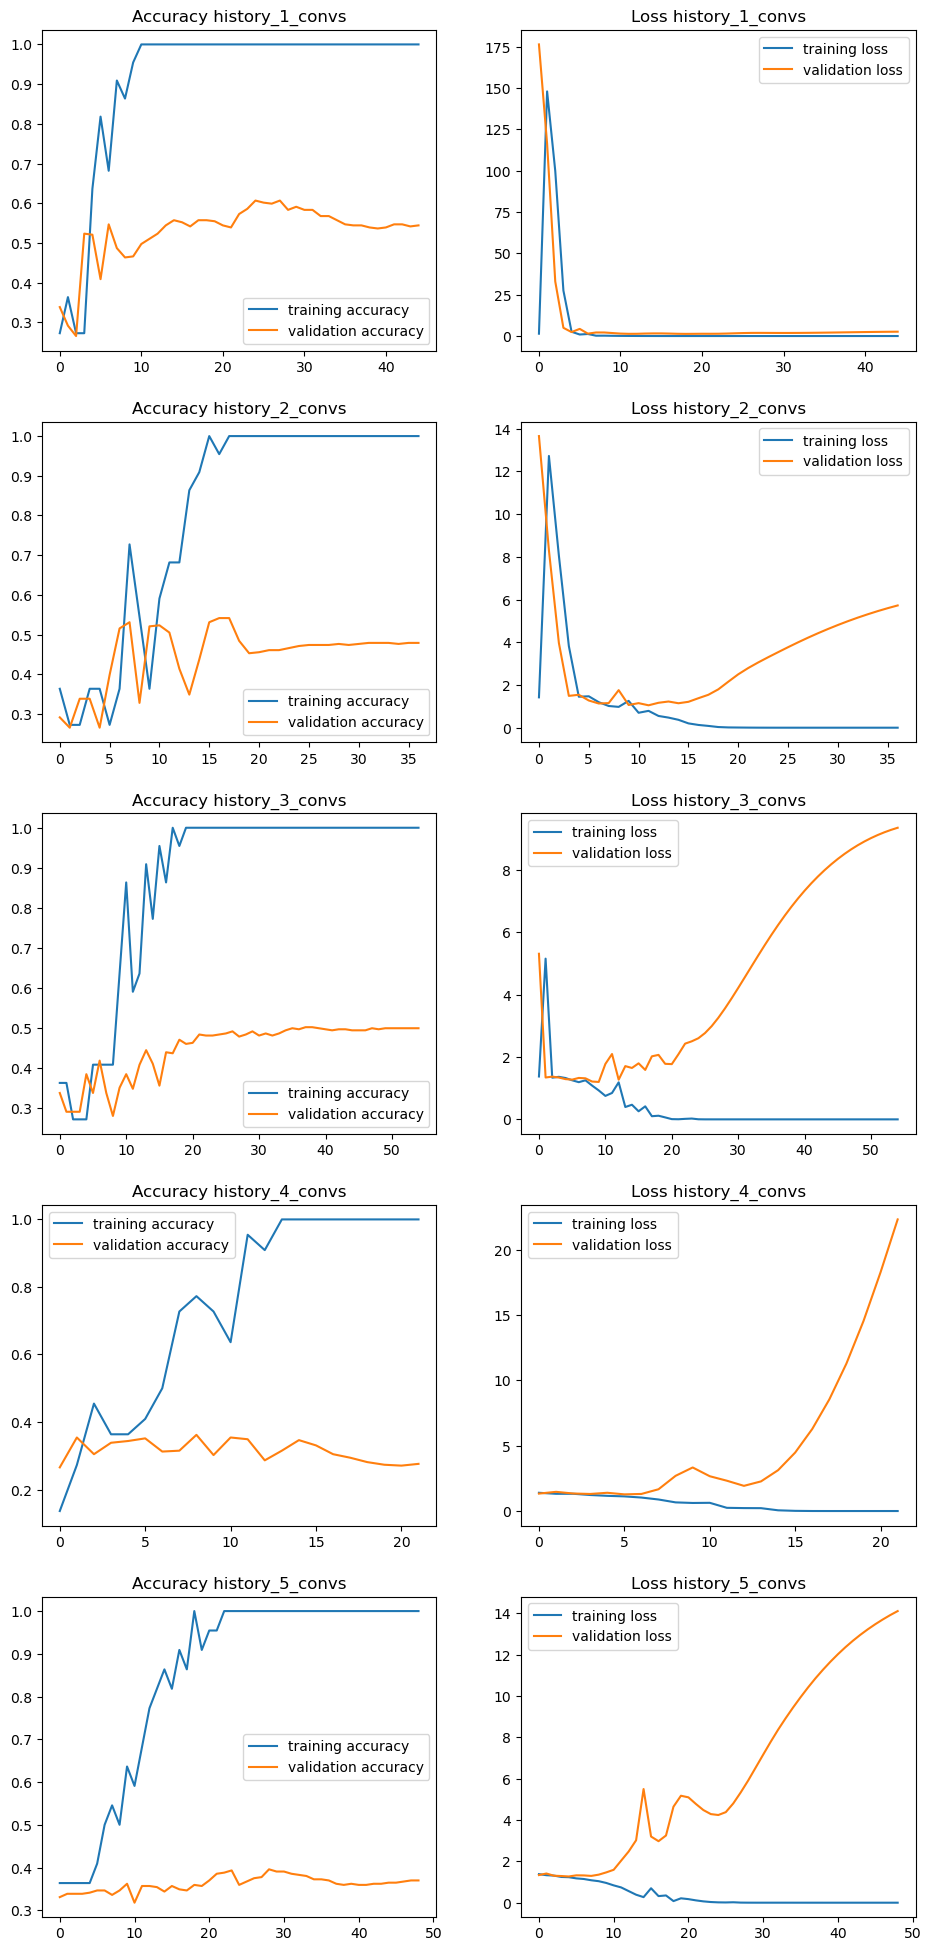

In [8]:
# multiplot training and validation  accuracy and loss from history csv files
def multiplot_history(history_files, save=False):
    
    fig, axs = plt.subplots( len(history_files), 2, figsize=(10, 20))
    fig.tight_layout(pad=3.0)
    for i in range(len(history_files)):
        history_df = pd.read_csv(history_files[i])
        # plot validation and training accuracy
        name = history_files[i].split('/')[-1].split('.')[0]
        axs[i,0].plot(history_df['accuracy'], label='training accuracy')
        axs[i,0].plot(history_df['val_accuracy'], label='validation accuracy')
        axs[i,0].set_title(f'Accuracy {name}')
        axs[i,0].legend()
        axs[i,1].plot(history_df['loss'], label='training loss')
        axs[i,1].plot(history_df['val_loss'], label='validation loss')
        axs[i,1].set_title(f'Loss {name}')
        axs[i,1].legend()

    if save:
        plt.savefig('multiplot_history.png')
    plt.show()

multiplot_history([f'./histories/history_{i}_convs.csv' for i in range(1,6)])

## 1.f Data Augmentation

Otra manera de evitar sobreajuste y mejorar los desempeños de una red convolucional es usar aumentación de datos. La idea detrás de este método es un hecho muy simple: si rotamos ligeramente una foto por ejemplo de un caballo, seguirá siendo de un caballo. Lo mismo si la movemos ligeramente hacia algun lado, hacia arriba, etc.

Keras trae implementado un generador de imágenes aumentadas como se muestra en el *código* a continuación. Explore a lo menos 4 variaciones del generador a continuación, la elección de los parámetros y sus respectivos valores queda en sus manos). Una vez generada la data aumentada, entrene la mejor red que haya obtenido a lo largo de toda la tarea.

Pregunta: ¿Mejora el desempeño de la red utilizando aumentación de datos?

$\textit{R:}$ Nuestra implementación no nos arrojo una mejora en el test set, pero esto puede ser debido a que la aumentación utilizada podría haber sido una mejor, o bien, nuestra mejor red tendría poco espacio de mejora, pues la arquitectura era bastante "simple".

In [32]:
from keras.preprocessing.image import ImageDataGenerator


def data_gen(X_train, y_train, X_val, y_val, X_test, y_test,rotation_range=0, width_shift_range=0, height_shift_range=0, vertical_flip=True):
    datagen_train = ImageDataGenerator(
                    rotation_range=rotation_range,
                    width_shift_range=width_shift_range,
                    height_shift_range=height_shift_range,
                    vertical_flip=vertical_flip,
                    fill_mode='nearest',
                    data_format="channels_last")

    datagen_val = ImageDataGenerator(
                    rotation_range=rotation_range,
                    width_shift_range=width_shift_range,
                    height_shift_range=height_shift_range,
                    vertical_flip=vertical_flip,
                    fill_mode='nearest',
                    data_format="channels_last")

    datagen_test = ImageDataGenerator(
                    rotation_range=rotation_range,
                    width_shift_range=width_shift_range,
                    height_shift_range=height_shift_range,
                    vertical_flip=vertical_flip,
                    fill_mode='nearest',
                    data_format="channels_last")
    datagen_train.fit(X_train)
    train_generaton = datagen_train.flow(X_train, y_train, batch_size=32)

    datagen_val.fit(X_val)
    val_generaton = datagen_val.flow(X_val, y_val, batch_size=32)

    datagen_test.fit(X_test)
    test_generaton = datagen_test.flow(X_test, y_test, batch_size=32)

    return train_generaton, val_generaton, test_generaton

def best_cnn(inputs, num_classes):
    x = inputs
    # create model    

    conv1  = Conv2D(filters = 128,
                    kernel_size = (3,3),
                    strides=(1, 1),
                    padding = 'same',
                    activation = 'relu',
                    data_format="channels_last")(x)

    pool1  = AveragePooling2D(strides=(5,5))(conv1)

    conv3  = Conv2D(filters = 128,
                    kernel_size = (3,3),
                    strides=(1, 1),
                    padding = 'same',
                    activation = 'relu',
                    data_format="channels_last")(pool1)


    pool2  = AveragePooling2D(strides=(5,5))(conv3)


    dense2 = Dense(units=32, activation='relu')(pool2)
    
    dense3 = Dense(units=num_classes, activation='softmax')(dense2)

    model  = Model(inputs = inputs, outputs = dense3)    
    
    return model
# ...

In [ ]:
import itertools  

flips = [True, False]
angles =  [20, 40]

for flips_, angles_ in itertools.product(flips, angles): 

    train_generaton, val_generaton, test_generaton = data_gen(X_train, y_train, X_val, y_val, X_test, y_test, rotation_range=angles_, vertical_flip=flips_)
    inputs = Input(shape=(256, 256, 3))
    num_classes = 4

    model = best_cnn(inputs, num_classes)
    epochs = 200

    my_callbacks = [History(), EarlyStopping(patience=20, min_delta=0.01, monitor='val_accuracy', mode="auto", restore_best_weights = True)]
    
    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'], run_eagerly=True)

    #fit model

    history = model.fit(train_generaton, validation_data=val_generaton, epochs=epochs, callbacks=my_callbacks)
    # save history of modedl
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(f'history_flips:{flips_}_angles:{angles_}_p1f.csv')

    #test model
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Loss in test data: {test_loss}\nAccuracy in test data: {test_acc}')
    # test model with augmented data
    gen_test_loss, gen_test_acc = model.evaluate(test_generaton)
    print(f'Loss in test data: {test_loss}\nAccuracy in test data: {test_acc}')
    # save model
    with open(f'test_results_flips:{flips_}_angles:{angles_}_p1f.csv', 'w') as f:
        f.write(f'Loss in test data: {test_loss}\nAccuracy in test data: {test_acc}')
        f.write(f'Loss in gen test data: {gen_test_loss}\nAccuracy in gen test data: {test_acc}')

    model.save(f'best_model_flips:{flips_}_angles:{angles_}_p1f')

    tf.keras.backend.clear_session()
    



Epoch 1/200


In [37]:
# save history of modedl
history_df = pd.DataFrame(history.history)
history_df.to_csv(f'history_best_cnn_p1f.csv')

# save model
model.save(f'model_best_cnn_p1f')


115/115 [==============================] - 163s 1s/step - loss: 1.0957 - accuracy: 0.6912
Loss in test data: 1.0956947803497314
Accuracy in test data: 0.6911925673484802
29/29 [==============================] - 172s 6s/step - loss: 1.0604 - accuracy: 0.6573
Loss in test data: 1.0956947803497314
Accuracy in test data: 0.6911925673484802


# Graficar history del mejor metodo para nuestro mejor modelo, el cual fue el flip True, angle 40.

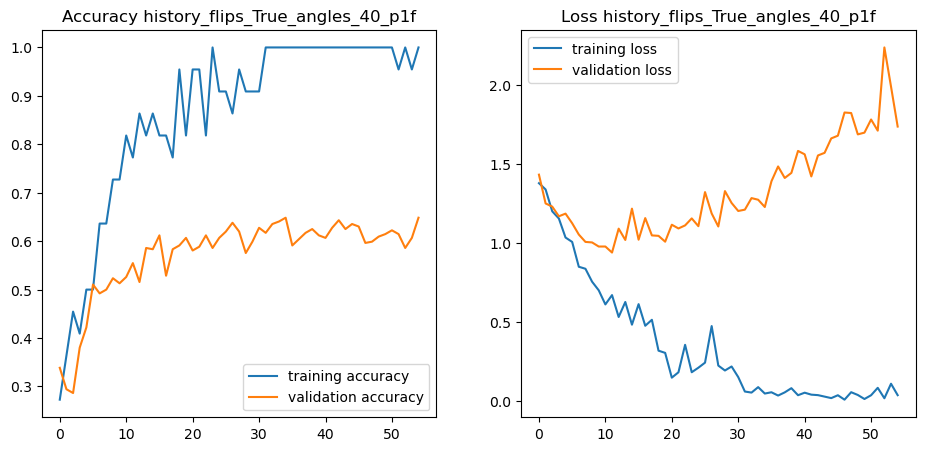

In [16]:

def plot_history(history_file, save=False):
    
    fig, axs = plt.subplots( 1, 2, figsize=(10, 5))
    fig.tight_layout(pad=3.0)
    history_df = pd.read_csv(history_file)
    # plot validation and training accuracy
    name = history_file.split('/')[-1].split('.')[0]
    axs[0].plot(history_df['accuracy'], label='training accuracy')
    axs[0].plot(history_df['val_accuracy'], label='validation accuracy')
    axs[0].set_title(f'Accuracy {name}')
    axs[0].legend()
    axs[1].plot(history_df['loss'], label='training loss')
    axs[1].plot(history_df['val_loss'], label='validation loss')
    axs[1].set_title(f'Loss {name}')
    axs[1].legend()

    if save:
        plt.savefig('multiplot_history.png')
    plt.show()

plot_history('./histories/history_flips_True_angles_40_p1f')


## 1.g Bloque Residual
## falta correr y concluir

A continuación se probaran arquitecturas de red con conexiones residuales, puede usar la data aumentada si le parece indicado.

<center><img src="https://production-media.paperswithcode.com/methods/resnet-e1548261477164.png" width="300"/></center>


En la imagen se muestra el bloque básico de la arquitectura de la primera variación de la Red Residual: ResNet (https://arxiv.org/abs/1512.03385). Investigue las principales motivaciones de cómo implementar este tipo de red, sus ventajas, sus desventajas y luego cree y entrene una red con 1, 2, 3, 4 y 5 bloques residuales. ¿Como deben ser las dimensiones del input $x$ y de $\mathcal{F}(x)$ para poder realizar la operación $\mathcal{F}(x) + x$ entes del *relu* de más abajo?, ¿qué tipo de padding hay que usar en la convolución para mantener las mismas dimensiones de entrada y de salida?

Este tipo de redes fueron creadas para sopesar el problema del gradiente desvaneciente, i.e., a medida que se van propagando las derivadas de la función de costo, estas van decreciendo dada la multiplicación que nos entrega la regla de la cadena, pero como los bloques residuales suman la entrada a la salida, los gradientes pueden fuluir a trabbes de los saltos de conexiones, haciendo que el gradiente no se disipe, lo que nos permite entrenar redes más profundas.

Las dimensiones de $x$ y $\mathcal{F}(x)$ deben ser iguales, por lo que se debe realizar un padding de ceros en la convolución, para que las dimensiones de entrada y salida sean iguales.

In [42]:
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow import Tensor

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net(num_blocks:int):
    
    inputs = Input(shape=X_train.shape[1:])
    num_filters = 64
    
    norm_1 = BatchNormalization()(inputs)
    conv_1= Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(norm_1)
    t = relu_bn(conv_1)
    
    num_blocks_list = np.ones(num_blocks, dtype=int)

    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(4, activation='softmax')(t)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
for n_blocks in [3,4,5]:
    print(f'Number of blocks: {n_blocks}')
    model = create_res_net(n_blocks) 
    callbacks = [History(), EarlyStopping(patience=20, min_delta=0.01, monitor='val_accuracy', mode="auto", restore_best_weights = True)]

    train_generaton, val_generaton, test_generaton = data_gen(X_train, y_train, X_val, y_val, X_test, y_test, rotation_range=20, vertical_flip=True)


    history = model.fit(train_generaton,
                        validation_data=val_generaton,
                        epochs=200,
                        verbose=1,
                        callbacks=callbacks
                        )
    # save history of modedl
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(f'history_inception_{n_blocks}_p1h.csv')

    # test model
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Loss in test data {test_loss}\n Accuracy in test data {test_acc}')
    # test model with augmented data
    gen_test_loss, gen_test_acc = model.evaluate(test_generaton)
    print(f'Loss in test data {test_loss}\n Accuracy in test data {test_acc}')
    # save model
    print(f'test_results_inceptios_{n_blocks}_p1h.csv')
    with open(f'test_results_inception_{n_blocks}_p1h.csv', 'w') as f:
        f.write(f'Loss in test data {test_loss}\nAccuracy in test data {test_acc}')
        f.write(f'Loss in gen test data {gen_test_loss}\nAccuracy in gen test data {test_acc}')

    model.save(f'best_model_inceptios_b_{n_blocks}_p1h.h5')

    tf.keras.backend.clear_session()

## 1.h Bloque Inception
## falta revisar código, correr y concluir

En preguntas anteriores se pidió probar con distintos tamaños de kernel, en este tipo de bloque la idea es usar varios tamaños al mismo tiempo y así extraer características de contextos grandes y pequeños.

Para comenzar es útil preguntarse: ¿Qué pasa si se desea modificar solamente el número de canales?. Existe una forma de mantener las dimensiones de entrada, modificando el número de canales de la salida: La convolución $1 \times 1$.

Imagine que tiene una matriz $M$ de tamaño $6 \times 6$, si realiza una convolución con una matriz $m$ de $1\times 1$ y luego una activación, entonces $M^{6 \times 6} * m^{1\times 1}$ será una multiplicación element-wise entre el valor de $m$ y cada elemento de $M$ resultando luego de la activación otra matriz de $6\times 6$. 

Teniendo en mente lo anterior, suponga ahora que la entrada es un arreglo de tamaño $(6 \times 6 \times 32)$, es decir, tiene 32 canales. Considere que desea aplicar una convolución con $N$ filtros a todos los canales, entonces el tamaño de los filtros debe ser $(1\times 1 \times 32)$, el resultado de la convolución será tendrá un tamaño $(6 \times 6 \times N)$. Por lo tanto es posible aumentar, mantener o disminuir la cantidad de canales de la salida. La idea de mantener los canales es aplicar una activación no lineal, lo que permite a la red aprender funciónes más complejas.

Otra ventaja de la convolución $(1\times 1)$ es que ayuda a reducir 
el costo computacional entre otras convoluciones, por ejemplo si se aplican 32 filtros de tamaño $(5\times 5 \times 192)$ con padding `same` a una entrada de tamaño $(28 \times 28 \times 192)$, entonces la salida será de tamaño $(28 \times 28 \times 32)$ y el total de multiplicaciones será: $28\times 28 \times 32 \times 5 \times 5 \times 192 = 120\; \text{Millones}$. Por esta razón al aplicar convoluciones con filtros de distintos tamaños conviene reducir el número de operaciones a través de la siguiente idea llamada "cuello de botella":

- A la entrada de $(28 \times 28 \times 192)$ aplique 16 filtros convolucionales de $(1 \times 1 \times 192)$, obteniendo una salida de $(28 \times 28 \times 16)$.

- Luego aplique 32 filtros convolucionales de $(5 \times 5 \times 16)$, obteniendo una salida de $(28 \times 28 \times 32)$.

Para la primera operación se requieren $28 \times 28 \times 16 \times 192 = 2.4\; \text{Millones}$ de multiplicaciones, mientras que en la segunda son $28 \times 28 \times 32 \times 5 \times 5 \times 16 = 10\; \text{Millones}$. Finalmente sumando ambas cantidades se obtiene un total de $12.4\; \text{Millones}$ de multiplicaciones, casi un 10% de lo que se obtiene al realizar la operación directamente!.

Con todo lo anterior en mente se le pide que implemente una red con una red utilizando el bloque presentado en la imagen de abajo. Pruebe con 1,3 y 4 bloques antes de aplicar las capas densas. Note que en la imagen la entrada y la salida conservan la dimensión de $(28 \times 28)$, por lo tanto entre cada bloque *inception* puede ir bajando dicha dimensión, para obtener más información sobre la construcción del bloque puede leer el siguiente documento https://arxiv.org/pdf/1409.4842.pdf.


<center><img src="https://blog.kakaocdn.net/dn/dvyzrN/btqNkQRUokj/DrrKv0t5QJ9CyRI45aosd1/img.jpg" width="1080"/><center/>

In [30]:
def di_caprio_model(inputs, n_classes, n_blocks):

    x = inputs

    ### 1st layer
    for i in range(n_blocks):
        layer_0 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

        layer_1 = Conv2D(96, (1,1), padding='same', activation='relu')(x)
        layer_1 = Conv2D(128, (3,3), padding='same', activation='relu')(layer_1)

        layer_2 = Conv2D(10, (1,1), padding='same', activation='relu')(x)
        layer_2 = Conv2D(10, (5,5), padding='same', activation='relu')(layer_2)

        layer_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
        layer_3 = Conv2D(10, (1,1), padding='same', activation='relu')(layer_3)

        concat = tf.keras.layers.concatenate([layer_0,layer_1, layer_2, layer_3], axis = 3)
        x = AveragePooling2D((3,3), strides=(2,2), padding='same')(concat)

    flat_1 = Flatten()(x)

    dense_1 = Dense(512, activation='relu')(flat_1)
    dense_2 = Dense(256, activation='relu')(dense_1)
    output = Dense(n_classes, activation='softmax')(dense_2)
    
    model = Model([inputs], output)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [35]:
with tf.device("/CPU:0"):
    for blocks in [1,3,4]:


        train_generaton, val_generaton, test_generaton = data_gen(X_train, y_train, X_val, y_val, X_test, y_test, rotation_range=20, vertical_flip=True)

        inputs = Input(shape=(256, 256, 3))

        num_classes = 4

        model = di_caprio_model(inputs, num_classes, blocks)
        epochs = 200

        my_callbacks = [History(), EarlyStopping(patience=20, min_delta=0.01, monitor='val_accuracy', mode="auto", restore_best_weights = True)]
        
        #compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'], run_eagerly=True)

        #fit model

        history = model.fit(train_generaton, validation_data=val_generaton, epochs=epochs, callbacks=my_callbacks)
        # save history of modedl
        history_df = pd.DataFrame(history.history)
        history_df.to_csv(f'history_inception_{blocks}_p1h.csv')

        #test model
        test_loss, test_acc = model.evaluate(X_test, y_test)
        print(f'Loss in test data: {test_loss}\nAccuracy in test data: {test_acc}')
        # test model with augmented data
        gen_test_loss, gen_test_acc = model.evaluate(test_generaton)
        print(f'Loss in test data: {test_loss}\nAccuracy in test data: {test_acc}')
        # save model
        with open(f'test_results_inception_{blocks}_p1h.csv', 'w') as f:
            f.write(f'Loss in test data: {test_loss}\nAccuracy in test data: {test_acc}')
            f.write(f'Loss in gen test data: {gen_test_loss}\nAccuracy in gen test data: {test_acc}')

        model.save(f'best_model_inceptios_{blocks}_p1h')

        tf.keras.backend.clear_session()
    



Epoch 1/200
1/1 [==============================] - 103s 103s/step - loss: 1.4237 - accuracy: 0.2727 - val_loss: 351.1399 - val_accuracy: 0.2526
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 339.5112 - accuracy: 0.3182

KeyboardInterrupt: 

## 1.i Transfer Learning


A continuación se le pide escoger 1 modelo pre entrenado de entre los presentes en la siguiente lista https://keras.io/api/applications/, puede usar alguno de los vistos a lo largo de la tarea o puede escoger otro que le parezca. En el link anterior y en el siguiente puede encontrar información acerca de los modelos, su implementación y otras consideraciones.

Preguntas: ¿Qué es Transfer Learning?, ¿Cómo se implementa Transfer Learning con un modelo pre entrenado? (explique brevemente)

$\textit{R: }$ El transfer learning consiste en utilizar conocimiento adquirido de la resolución de otros problemas, es decir utilizar modelos que han sido diseñados y han surgido como respuestas a otros problemas parecidos al que se desea abordar. Lo que permité comenzar con modelos pre entrenados. se puede implementar de distintas formas, tales como utilizar un extractor de features o realizar un ajuste en los modelos pre entrenados.

In [15]:
X_train.shape[1 :]

(256, 256, 3)

In [17]:
import tensorflow_hub as hub

In [29]:
from tensorflow.keras.utils import Sequence
import numpy as np   

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [20]:
base_model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5")
])
base_model.build([None, 224, 224, 3])
base_model.trainable = False

In [22]:
inputs = tf.keras.Input((None, None, 3))
resize = tf.keras.layers.Resizing(224, 224)(inputs)
x = base_model(resize, training = False)
hidden = tf.keras.layers.Dense(32, activation = "relu")(x)
outputs = tf.keras.layers.Dense(4, activation = "softmax")(hidden)

In [23]:
model = tf.keras.Model(inputs = inputs, outputs = outputs)

In [24]:
for layer in base_model.layers:
    layer.trainable = False

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 1001)              5508713   
                                                                 
 dense (Dense)               (None, 32)                32064     
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 5,540,909
Trainable params: 32,196
Non-trainable params: 5,508,713
_________________________________________________________________


In [26]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = tf.keras.metrics.CategoricalAccuracy()
)

In [30]:
train_gen = DataGenerator(X_train, y_train, 8)
test_gen = DataGenerator(X_test, y_test, 8)

In [31]:
model.fit(train_gen, epochs = 100, validation_data = test_gen, callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)])

Epoch 1/100
3/3 [==============================] - 10s 4s/step - loss: 0.4415 - categorical_accuracy: 0.9545 - val_loss: 1.2655 - val_categorical_accuracy: 0.4844
Epoch 2/100
3/3 [==============================] - 7s 3s/step - loss: 0.1971 - categorical_accuracy: 1.0000 - val_loss: 1.1847 - val_categorical_accuracy: 0.5104
Epoch 3/100
3/3 [==============================] - 7s 3s/step - loss: 0.0916 - categorical_accuracy: 1.0000 - val_loss: 1.2261 - val_categorical_accuracy: 0.5189
Epoch 4/100
3/3 [==============================] - 7s 3s/step - loss: 0.0461 - categorical_accuracy: 1.0000 - val_loss: 1.2992 - val_categorical_accuracy: 0.5129
Epoch 5/100
3/3 [==============================] - 6s 3s/step - loss: 0.0274 - categorical_accuracy: 1.0000 - val_loss: 1.3000 - val_categorical_accuracy: 0.5345
Epoch 6/100
3/3 [==============================] - 7s 3s/step - loss: 0.0145 - categorical_accuracy: 1.0000 - val_loss: 1.2844 - val_categorical_accuracy: 0.5498
Epoch 7/100
3/3 [==========

In [59]:
base_model.trainable = True

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = tf.keras.metrics.CategoricalAccuracy()
)

In [60]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 1001)              5508713   
                                                                 
 dense (Dense)               (None, 32)                32064     
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 5,540,909
Trainable params: 5,484,313
Non-trainable params: 56,596
_________________________________________________________________


In [61]:
model.fit(train_gen, epochs = 100, validation_data = test_gen, callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)])

Epoch 1/100
3/3 [==============================] - 22s 5s/step - loss: 2.0267 - categorical_accuracy: 0.3636 - val_loss: 1.6998 - val_categorical_accuracy: 0.4426
Epoch 2/100
3/3 [==============================] - 7s 4s/step - loss: 2.0593 - categorical_accuracy: 0.2273 - val_loss: 2.4404 - val_categorical_accuracy: 0.3063
Epoch 3/100
3/3 [==============================] - 7s 4s/step - loss: 1.9676 - categorical_accuracy: 0.1818 - val_loss: 3.0712 - val_categorical_accuracy: 0.2311
Epoch 4/100
3/3 [==============================] - 7s 4s/step - loss: 1.8902 - categorical_accuracy: 0.3182 - val_loss: 3.4912 - val_categorical_accuracy: 0.1945
Epoch 5/100
3/3 [==============================] - 8s 4s/step - loss: 1.9804 - categorical_accuracy: 0.2727 - val_loss: 3.5979 - val_categorical_accuracy: 0.1819
Epoch 6/100
3/3 [==============================] - 8s 4s/step - loss: 1.9509 - categorical_accuracy: 0.2273 - val_loss: 3.4797 - val_categorical_accuracy: 0.1786
